# Segmenting and Clustering Neighborhoods in Gold Coast

## Download all dependencies

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder
import requests
print('Libraries imported.')

Libraries imported.


## Scrape Gold Coast Neighborhood Data

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_Gold_Coast_suburbs'
dfs =pd.read_html(url)

# Print all dataframes from html
for df in dfs:
    print(df)

  Suburbs in the City of Gold Coast  \
0                               NaN   
1                          Location   
2                            Number   
3                       Populations   
4                             Areas   
5                      Subdivisions   

                 Suburbs in the City of Gold Coast.1  
0                                                NaN  
1                                 City of Gold Coast  
2                                         81 suburbs  
3  0 (Southern Moreton Bay Islands) – 31,908 (Sou...  
4  0.6 square kilometres (0.23 sq mi) (Steiglitz)...  
5                                     Neighbourhoods  
                            Name      Type Postcode  Population              \
                            Name      Type Postcode 2016 census 2011 census   
0                    Advancetown  Locality     4211         482       352.0   
1                       Alberton  Locality     4207         590       576.0   
2                        

The third table contains the suburb data of Gold Coast that is relevant

In [3]:
df = dfs[1]
df = df[['Name','Type','Postcode','Population']]
df.columns = df.columns.droplevel()
df.drop(['2011 census','Change'],axis=1,inplace=True)
df.rename(columns={'Name': "Suburb", '2016 census':'2016 Population'}, inplace=True)
df['2016 Population'] = df['2016 Population'].astype(int)
df.head()

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Suburb,Type,Postcode,2016 Population
0,Advancetown,Locality,4211,482
1,Alberton,Locality,4207,590
2,Arundel,Suburb,4214,10246
3,Ashmore,Suburb,4214,11910
4,Austinville,Locality,4213,356


Remove all 'Locality's such that only Suburbs are left as part of the dataset

In [4]:
df=df[df['Type']=='Suburb'].reset_index(drop=True)
display(df.head(10))

# Remove the column 'Type', as it is no longer needed
df.drop('Type', axis=1, inplace =True)
display(df.head(10))

print("Size of dataframe:", df.shape)


,Suburb,Type,Postcode,2016 Population
0,Arundel,Suburb,4214,10246
1,Ashmore,Suburb,4214,11910
2,Benowa,Suburb,4217,8741
3,Biggera Waters,Suburb,4216,8534
4,Bilinga,Suburb,4225,1804
5,Broadbeach,Suburb,4218,5514
6,Broadbeach Waters,Suburb,4218,7779
7,Bundall,Suburb,4217,4523
8,Burleigh Heads,Suburb,4220[a],10077
9,Burleigh Waters,Suburb,4220,14310


,Suburb,Postcode,2016 Population
0,Arundel,4214,10246
1,Ashmore,4214,11910
2,Benowa,4217,8741
3,Biggera Waters,4216,8534
4,Bilinga,4225,1804
5,Broadbeach,4218,5514
6,Broadbeach Waters,4218,7779
7,Bundall,4217,4523
8,Burleigh Heads,4220[a],10077
9,Burleigh Waters,4220,14310


Size of dataframe: (52, 3)


Notice that there are suberbs with duplicates Postcodes, denoted by Postcode = XXXX and XXXX[a]

In [5]:
print(df['Postcode'].unique())

['4214' '4217' '4216' '4225' '4218' '4220[a]' '4220' '4211' '4226' '4209'
 '4223' '4221' '4212' '4208' '4215' '4213' '4210' '4227' '4228' '4224'
 '4207']


Remove all strings from the Postcode column and merge suburbs that have the same Postcode into one row

In [6]:
# Extract string characters from Postcode
df['Postcode']= df['Postcode'].str.extract('(\d+)', expand=False)

# Merge Suburbs with the same postcode
df =(df.groupby('Postcode')
   .agg({'Suburb' : ', '.join,'2016 Population':'sum'})
   .sort_values('Suburb')
   .reset_index()
   .reindex(columns=df.columns))

display(df)
print("Dataframe size:", df.shape)

,Suburb,Postcode,2016 Population
0,"Arundel, Ashmore, Molendinar, Parkwood",4214,37233
1,"Benowa, Bundall, Main Beach, Surfers Paradise",4217,40836
2,"Biggera Waters, Coombabah, Hollywell, Paradise...",4216,37391
3,"Bilinga, Coolangatta",4225,7752
4,"Broadbeach, Broadbeach Waters, Mermaid Beach, ...",4218,31871
5,"Burleigh Heads, Burleigh Waters, Miami",4220,31230
6,"Carrara, Highland Park, Nerang, Pacific Pines",4211,52255
7,"Clear Island Waters, Merrimac, Robina",4226,34297
8,"Coomera, Pimpama, Upper Coomera",4209,47977
9,"Currumbin, Currumbin Waters",4223,12041


Dataframe size: (20, 3)


### Compute the coordinates for the corresponding Postcode(s)

In [7]:
def get_geocoder(postal_code_from_df):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Gold Coast, Queensland, Australia'.format(postal_code_from_df))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

df_loc = df

df_loc['Latitude'], df_loc['Longitude'] = zip(*df_loc['Postcode'].apply(get_geocoder))
df_loc

,Suburb,Postcode,2016 Population,Latitude,Longitude
0,"Arundel, Ashmore, Molendinar, Parkwood",4214,37233,-27.961448,153.369775
1,"Benowa, Bundall, Main Beach, Surfers Paradise",4217,40836,-28.010320,153.388423
2,"Biggera Waters, Coombabah, Hollywell, Paradise...",4216,37391,-27.916455,153.376175
3,"Bilinga, Coolangatta",4225,7752,-28.164080,153.513242
4,"Broadbeach, Broadbeach Waters, Mermaid Beach, ...",4218,31871,-28.045100,153.412372
5,"Burleigh Heads, Burleigh Waters, Miami",4220,31230,-28.090163,153.431955
6,"Carrara, Highland Park, Nerang, Pacific Pines",4211,52255,-28.003917,153.273565
7,"Clear Island Waters, Merrimac, Robina",4226,34297,-28.074371,153.396415
8,"Coomera, Pimpama, Upper Coomera",4209,47977,-27.850325,153.294098
9,"Currumbin, Currumbin Waters",4223,12041,-28.187680,153.420190


## Use Geopy library to get the latiutude and longitude values of Gold Coast city

In [8]:
address = 'Gold Coast, Queensland'

geolocator = Nominatim(user_agent="Aus_explorer")
location = geolocator.geocode(address)
latitude_gc = location.latitude
longitude_gc = location.longitude
print('The geograpical coordinate of Gold Coast are {}, {}.'.format(latitude_gc, longitude_gc))


The geograpical coordinate of Gold Coast are -28.0023731, 153.4145987.


## Create a map of Gold Coast with suburbs superimposed on top

In [9]:
map_gold_coast = folium.Map(location=[latitude_gc, longitude_gc], zoom_start=10)

# add markers to map
for lat, lng, sub in zip(df_loc['Latitude'], df_loc['Longitude'], df_loc['Suburb']):
    label =  '{}'.format(sub)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gold_coast)  

map_gold_coast

## Utilise Foursquare API to explore the suburbs and segment

In [10]:
# Define Foursquare Credentials and Version
CLIENT_ID = '15P5L5SR5EZVOCWG515NXJ3ZSJTFEBLDLRTXL5SSVLDOUONU' # your Foursquare ID
CLIENT_SECRET = 'WMF0HKUSBQMDIGKEJDLVVPZRLZYOKJOPPBMWCXLB0E54LCBM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 15P5L5SR5EZVOCWG515NXJ3ZSJTFEBLDLRTXL5SSVLDOUONU
CLIENT_SECRET:WMF0HKUSBQMDIGKEJDLVVPZRLZYOKJOPPBMWCXLB0E54LCBM


## Create a function to obtain the top 100 venues that are in each suburn within a radius of 1000 metre

In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
Gold_Coast_venues = getNearbyVenues(names=df_loc['Suburb'],
                                   latitudes=df_loc['Latitude'],
                                   longitudes=df_loc['Longitude']
                                  )

Arundel, Ashmore, Molendinar, Parkwood
Benowa, Bundall, Main Beach, Surfers Paradise
Biggera Waters, Coombabah, Hollywell, Paradise Point, Runaway Bay
Bilinga, Coolangatta
Broadbeach, Broadbeach Waters, Mermaid Beach, Mermaid Waters
Burleigh Heads, Burleigh Waters, Miami
Carrara, Highland Park, Nerang, Pacific Pines
Clear Island Waters, Merrimac, Robina
Coomera, Pimpama, Upper Coomera
Currumbin, Currumbin Waters
Elanora, Palm Beach
Helensvale, Hope Island
Jacobs Well, Ormeau
Labrador, Southport
Mudgeeraba, Neranwood, Tallai, Worongary
Oxenford
Reedy Creek, Varsity Lakes
Tallebudgera
Tugun
Yatala


### Check how many venues are returned for each suburb

In [13]:
Gold_Coast_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Arundel, Ashmore, Molendinar, Parkwood",2,2,2,2,2,2
"Benowa, Bundall, Main Beach, Surfers Paradise",14,14,14,14,14,14
"Biggera Waters, Coombabah, Hollywell, Paradise Point, Runaway Bay",3,3,3,3,3,3
"Bilinga, Coolangatta",17,17,17,17,17,17
"Broadbeach, Broadbeach Waters, Mermaid Beach, Mermaid Waters",11,11,11,11,11,11
"Burleigh Heads, Burleigh Waters, Miami",2,2,2,2,2,2
"Clear Island Waters, Merrimac, Robina",1,1,1,1,1,1
"Coomera, Pimpama, Upper Coomera",4,4,4,4,4,4
"Currumbin, Currumbin Waters",1,1,1,1,1,1


## Analyze each neighborhood via one hot encoding

In [14]:
# one hot encoding
GC_onehot = pd.get_dummies(Gold_Coast_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
GC_onehot['Neighborhood'] = Gold_Coast_venues['Neighborhood'] 

# move neighborhood column to the first column
GC_onehot = GC_onehot[['Neighborhood'] + [ col for col in GC_onehot.columns if col != 'Neighborhood' ] ]

display(GC_onehot.head())
print(GC_onehot.shape)

,Neighborhood,Airport,Airport Lounge,Airport Terminal,Athletics & Sports,Bakery,Beach,Botanical Garden,Burger Joint,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Dive Shop,Duty-free Shop,Fast Food Restaurant,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Harbor / Marina,Home Service,Hostel,Japanese Restaurant,Juice Bar,Malay Restaurant,Martial Arts Dojo,Moving Target,Noodle House,Office,Paper / Office Supplies Store,Park,Pizza Place,Playground,Resort,Sandwich Place,Shopping Mall,Supermarket,Sushi Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Video Game Store
0,"Arundel, Ashmore, Molendinar, Parkwood",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Arundel, Ashmore, Molendinar, Parkwood",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Benowa, Bundall, Main Beach, Surfers Paradise",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Benowa, Bundall, Main Beach, Surfers Paradise",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Benowa, Bundall, Main Beach, Surfers Paradise",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


(72, 49)


### Group rows by suburb and taking the mean of the frequency of occurence of each category

In [15]:
GC_grouped = GC_onehot.groupby('Neighborhood').mean().reset_index()
display(GC_grouped)
print(GC_grouped.shape)


,Neighborhood,Airport,Airport Lounge,Airport Terminal,Athletics & Sports,Bakery,Beach,Botanical Garden,Burger Joint,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Dive Shop,Duty-free Shop,Fast Food Restaurant,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Harbor / Marina,Home Service,Hostel,Japanese Restaurant,Juice Bar,Malay Restaurant,Martial Arts Dojo,Moving Target,Noodle House,Office,Paper / Office Supplies Store,Park,Pizza Place,Playground,Resort,Sandwich Place,Shopping Mall,Supermarket,Sushi Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Video Game Store
0,"Arundel, Ashmore, Molendinar, Parkwood",0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.5,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,"Benowa, Bundall, Main Beach, Surfers Paradise",0.000000,0.000000,0.000000,0.0,0.071429,0.000000,0.071429,0.071429,0.000000,0.142857,0.000000,0.071429,0.000000,0.071429,0.0,0.0,0.0,0.000000,0.071429,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.071429,0.071429,0.071429,0.071429,0.071429,0.0,0.000000,0.0,0.071429
2,"Biggera Waters, Coombabah, Hollywell, Paradise...",0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,"Bilinga, Coolangatta",0.058824,0.058824,0.058824,0.0,0.000000,0.058824,0.000000,0.058824,0.000000,0.117647,0.000000,0.000000,0.058824,0.058824,0.0,0.0,0.0,0.058824,0.058824,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.058824,0.000000,0.058824,0.000000,0.0,0.0,0.000000,0.058824,0.000000,0.000000,0.0,0.0,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,"Broadbeach, Broadbeach Waters, Mermaid Beach, ...",0.000000,0.000000,0.000000,0.0,0.181818,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.090909,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.090909,0.000000,0.090909,0.0,0.0,0.090909,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.090909,0.181818,0.000000,0.000000,0.0,0.000000,0.0,0.000000
5,"Burleigh Heads, Burleigh Waters, Miami",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.0,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
6,"Clear Island Waters, Merrimac, Robina",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
7,"Coomera, Pimpama, Upper Coomera",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.25,0.000000,0.0,0.25,0.25,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
8,"Currumbin, Currumbin Waters",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00

(14, 49)


### Print each neighborhood along with the top 5 most common venues

In [16]:
num_top_venues = 5

for hood in GC_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = GC_grouped[GC_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arundel, Ashmore, Molendinar, Parkwood----
                 venue  freq
0      Harbor / Marina   0.5
1               Bakery   0.5
2          Pizza Place   0.0
3  Japanese Restaurant   0.0
4            Juice Bar   0.0


----Benowa, Bundall, Main Beach, Surfers Paradise----
                  venue  freq
0                  Café  0.14
1      Video Game Store  0.07
2  Fast Food Restaurant  0.07
3        Sandwich Place  0.07
4         Shopping Mall  0.07


----Biggera Waters, Coombabah, Hollywell, Paradise Point, Runaway Bay----
                           venue  freq
0                        Airport  0.33
1  Paper / Office Supplies Store  0.33
2                           Park  0.33
3                 Airport Lounge  0.00
4                         Hostel  0.00


----Bilinga, Coolangatta----
            venue  freq
0            Café  0.12
1         Airport  0.06
2  Clothing Store  0.06
3          Hostel  0.06
4  Airport Lounge  0.06


----Broadbeach, Broadbeach Waters, Mermaid Beach, Mermai

### Summarize the top 10 common venues in a dataframe

In [17]:
# Create function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = GC_grouped['Neighborhood']

for ind in np.arange(GC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(GC_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arundel, Ashmore, Molendinar, Parkwood",Harbor / Marina,Bakery,Clothing Store,Gourmet Shop,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
1,"Benowa, Bundall, Main Beach, Surfers Paradise",Café,Video Game Store,Sandwich Place,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Botanical Garden,Bakery,Burger Joint,Theater
2,"Biggera Waters, Coombabah, Hollywell, Paradise...",Airport,Paper / Office Supplies Store,Park,Airport Terminal,Athletics & Sports,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop
3,"Bilinga, Coolangatta",Café,Burger Joint,Fast Food Restaurant,Duty-free Shop,Hostel,Juice Bar,Coffee Shop,Clothing Store,Office,Airport
4,"Broadbeach, Broadbeach Waters, Mermaid Beach, ...",Bakery,Supermarket,Caribbean Restaurant,Noodle House,Fast Food Restaurant,Shopping Mall,Japanese Restaurant,Malay Restaurant,Café,Duty-free Shop
5,"Burleigh Heads, Burleigh Waters, Miami",Home Service,Moving Target,Video Game Store,Clothing Store,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
6,"Clear Island Waters, Merrimac, Robina",Martial Arts Dojo,Video Game Store,Gym,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store,Construction & Landscaping
7,"Coomera, Pimpama, Upper Coomera",Gym / Fitness Center,Gift Shop,Supermarket,Gym,Chinese Restaurant,Golf Course,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
8,"Currumbin, Currumbin Waters",Café,Video Game Store,Clothing Store,Gourmet Shop,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
9,"Elanora, Palm Beach",Supermarket,Shopping Mall,Coffee Shop,Pizza Place,Gourmet Shop,Video Game Store,Chinese Restaurant,Gift Shop,Fast Food Restaurant,Duty-free Shop


### Cluster the neighborhoods

Find the optimal value of K by using elbow method

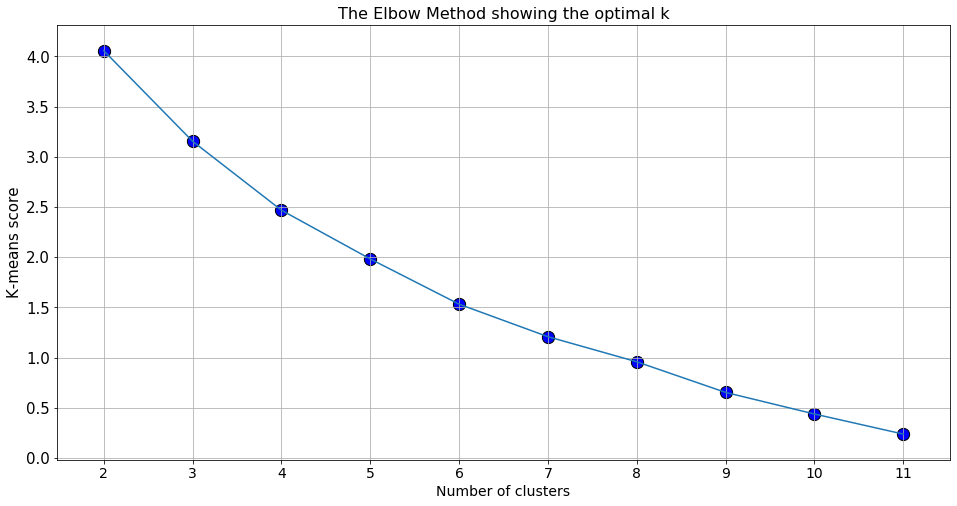

In [19]:
# create storage vector for intertia
GC_grouped_clustering  = GC_grouped.drop('Neighborhood', 1)

intertia = []
Ks = range(2,12)
for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=0).fit(GC_grouped_clustering)
    intertia.append(kmeans.inertia_)
    
# Plot the distortions of K-Means and observe for elbow point
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(Ks, intertia, markersize=1000)
plt.scatter(Ks,intertia,s=150,edgecolor='k',color = 'b')
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.title('The Elbow Method showing the optimal k',fontsize=16)
plt.xticks(Ks,fontsize=14)
plt.yticks(fontsize=15)
plt.show()

    

### Silhouette coefficient — a better metric

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
scaler = MinMaxScaler()

X_scaled=scaler.fit_transform(GC_grouped_clustering)
km_scores= []
km_silhouette = []
db_score = []

for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    print("-"*100)

Score for number of cluster(s) 2: -38.44189836137888
Silhouette score for number of cluster(s) 2: 0.30620986908178
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 3: -33.259608843537414
Silhouette score for number of cluster(s) 3: 0.1445418234572195
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 4: -25.92727272727273
Silhouette score for number of cluster(s) 4: 0.165459498294629
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 5: -22.18
Silhouette score for number of cluster(s) 5: 0.09251591644255422
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 6: -17.555555555555557
Silhouette score for number of cluster(s) 6: 0.11241855397212812
----------------------

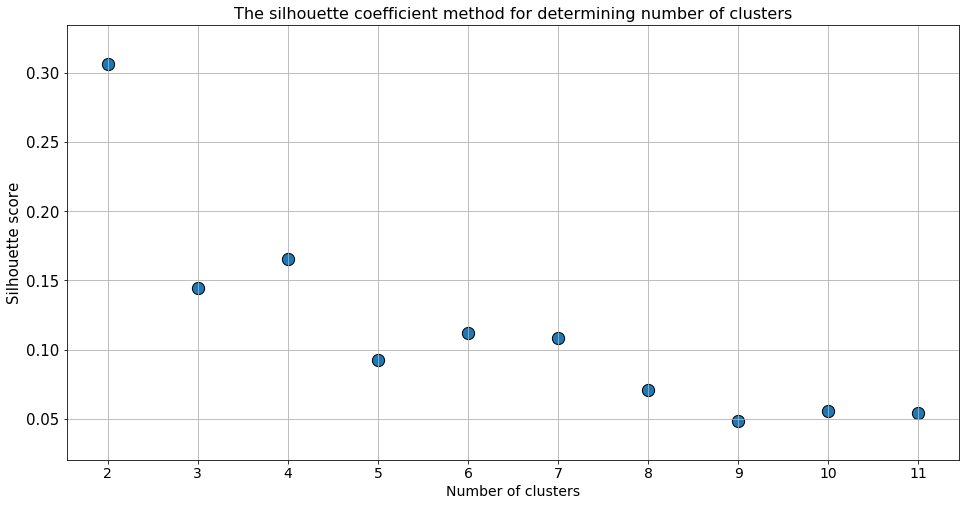

In [21]:
plt.figure(figsize=(16,8))
plt.title("The silhouette coefficient method for determining number of clusters",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Run k means to cluster the neighborhood into 6 clusters

In [22]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(GC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0])

Create new dataframe that includes the cluster aswell as the top 10 most common venues for each neighborhood

In [23]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted
GC_merged = df_loc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
GC_merged = GC_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Suburb')
GC_merged['Suburb']

0                Arundel, Ashmore, Molendinar, Parkwood
1         Benowa, Bundall, Main Beach, Surfers Paradise
2     Biggera Waters, Coombabah, Hollywell, Paradise...
3                                  Bilinga, Coolangatta
4     Broadbeach, Broadbeach Waters, Mermaid Beach, ...
5                Burleigh Heads, Burleigh Waters, Miami
6         Carrara, Highland Park, Nerang, Pacific Pines
7                 Clear Island Waters, Merrimac, Robina
8                       Coomera, Pimpama, Upper Coomera
9                           Currumbin, Currumbin Waters
10                                  Elanora, Palm Beach
11                              Helensvale, Hope Island
12                                  Jacobs Well, Ormeau
13                                  Labrador, Southport
14             Mudgeeraba, Neranwood, Tallai, Worongary
15                                             Oxenford
16                           Reedy Creek, Varsity Lakes
17                                         Talle

Set suburbs with NaN values as cluster as class 7

In [24]:
GC_merged['Cluster Labels'].fillna(3, inplace =True)
GC_merged

,Suburb,Postcode,2016 Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arundel, Ashmore, Molendinar, Parkwood",4214,37233,-27.961448,153.369775,0.0,Harbor / Marina,Bakery,Clothing Store,Gourmet Shop,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
1,"Benowa, Bundall, Main Beach, Surfers Paradise",4217,40836,-28.010320,153.388423,0.0,Café,Video Game Store,Sandwich Place,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Botanical Garden,Bakery,Burger Joint,Theater
2,"Biggera Waters, Coombabah, Hollywell, Paradise...",4216,37391,-27.916455,153.376175,0.0,Airport,Paper / Office Supplies Store,Park,Airport Terminal,Athletics & Sports,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop
3,"Bilinga, Coolangatta",4225,7752,-28.164080,153.513242,0.0,Café,Burger Joint,Fast Food Restaurant,Duty-free Shop,Hostel,Juice Bar,Coffee Shop,Clothing Store,Office,Airport
4,"Broadbeach, Broadbeach Waters, Mermaid Beach, ...",4218,31871,-28.045100,153.412372,0.0,Bakery,Supermarket,Caribbean Restaurant,Noodle House,Fast Food Restaurant,Shopping Mall,Japanese Restaurant,Malay Restaurant,Café,Duty-free Shop
5,"Burleigh Heads, Burleigh Waters, Miami",4220,31230,-28.090163,153.431955,0.0,Home Service,Moving Target,Video Game Store,Clothing Store,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
6,"Carrara, Highland Park, Nerang, Pacific Pines",4211,52255,-28.003917,153.273565,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Clear Island Waters, Merrimac, Robina",4226,34297,-28.074371,153.396415,1.0,Martial Arts Dojo,Video Game Store,Gym,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store,Construction & Landscaping
8,"Coomera, Pimpama, Upper Coomera",4209,47977,-27.850325,153.294098,0.0,Gym / Fitness Center,Gift Shop,Supermarket,Gym,Chinese Restaurant,Golf Course,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
9,"Currumbin, Currumbin Waters",4223,12041,-28.187680,153.420190,2.0,Café,Video Game Store,Clothing Store,Gourmet Shop,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store


# Choropleth

In [25]:
#geojsonfile
QLD_geo = r'gold_coast.geojson'
QLD_geo

'gold_coast.geojson'

## Visualize the resulting clusters

In [69]:
# create map
map_clusters = folium.Map(location=[latitude_gc+0.08, longitude_gc], zoom_start=10,width='50%', height='85%')

map_clusters.choropleth(
    geo_data=QLD_geo,
    data=df,
    columns=['Suburb', '2016 Population'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.8, 
    line_opacity=0.6,
    legend_name='Suburb Population')

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow= ['#8000ff', '#2adddd', '#00CD00', '#FF69B4']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(GC_merged['Latitude'], GC_merged['Longitude'], GC_merged['Suburb'], GC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## Examine Clusters

#### Cluster 1 - Dining/Grocery/Mall

In [27]:
GC_merged.loc[GC_merged['Cluster Labels'] == 0, GC_merged.columns[[1] + list(range(5, GC_merged.shape[1]))]]

,Postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4214,0.0,Harbor / Marina,Bakery,Clothing Store,Gourmet Shop,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
1,4217,0.0,Café,Video Game Store,Sandwich Place,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Botanical Garden,Bakery,Burger Joint,Theater
2,4216,0.0,Airport,Paper / Office Supplies Store,Park,Airport Terminal,Athletics & Sports,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop
3,4225,0.0,Café,Burger Joint,Fast Food Restaurant,Duty-free Shop,Hostel,Juice Bar,Coffee Shop,Clothing Store,Office,Airport
4,4218,0.0,Bakery,Supermarket,Caribbean Restaurant,Noodle House,Fast Food Restaurant,Shopping Mall,Japanese Restaurant,Malay Restaurant,Café,Duty-free Shop
5,4220,0.0,Home Service,Moving Target,Video Game Store,Clothing Store,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
8,4209,0.0,Gym / Fitness Center,Gift Shop,Supermarket,Gym,Chinese Restaurant,Golf Course,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
10,4221,0.0,Supermarket,Shopping Mall,Coffee Shop,Pizza Place,Gourmet Shop,Video Game Store,Chinese Restaurant,Gift Shop,Fast Food Restaurant,Duty-free Shop
11,4212,0.0,Track,Golf Course,Business Service,Video Game Store,Chinese Restaurant,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store
13,4215,0.0,Trail,Thrift / Vintage Store,Dive Shop,Convenience Store,Business Service,Clothing Store,Gourmet Shop,Golf Course,Gift Shop,Fast Food Restaurant


#### Cluster 2 Sports + Sports Stores

In [28]:
GC_merged.loc[GC_merged['Cluster Labels'] == 1, GC_merged.columns[[1] + list(range(5, GC_merged.shape[1]))]]

,Postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,4226,1.0,Martial Arts Dojo,Video Game Store,Gym,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store,Construction & Landscaping


#### Cluster 3 Cafes

In [29]:
GC_merged.loc[GC_merged['Cluster Labels'] == 2, GC_merged.columns[[1] + list(range(5, GC_merged.shape[1]))]]

,Postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,4223,2.0,Café,Video Game Store,Clothing Store,Gourmet Shop,Golf Course,Gift Shop,Fast Food Restaurant,Duty-free Shop,Dive Shop,Convenience Store


#### Cluster 3 No Recorded Venues

In [70]:
GC_merged.loc[GC_merged['Cluster Labels'] == 3, GC_merged.columns[[1] + list(range(5, GC_merged.shape[1]))]]

,Postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,4211,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,4208,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,4213,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,4210,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,4228,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,4207,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
